## Simulate and Plot Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
from jax import lax

from pfjax.particle_filter import particle_filter as pf
from pfjax import particle_filter_mvn as pfmvn
from pfjax.particle_filter import joint_loglik, particle_loglik
from pfjax import proj_data, simulate
from pfjax.lotvol_model import LotVolModel

In [3]:
key = random.PRNGKey(0)

# parameter values

alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.25
tau_l = 0.25

theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])

dt = 0.1
n_res = 1
n_obs = 50
lotvol_model = LotVolModel(dt, n_res) 
key, subkey = random.split(key)


x_init = lotvol_model.init_sample(y_init=jnp.log(jnp.array([5., 3.])),
                     theta=jnp.append(theta[0:6], jnp.array([0., 0.])),
                     key=subkey)

y_meas, x_state = simulate(lotvol_model, n_obs, x_init, theta, subkey)

Plotting the observations of the state (latent variables) as well as the observations. The latent observations are the smooth lines given below and the observations are the slightly more jagged lines.

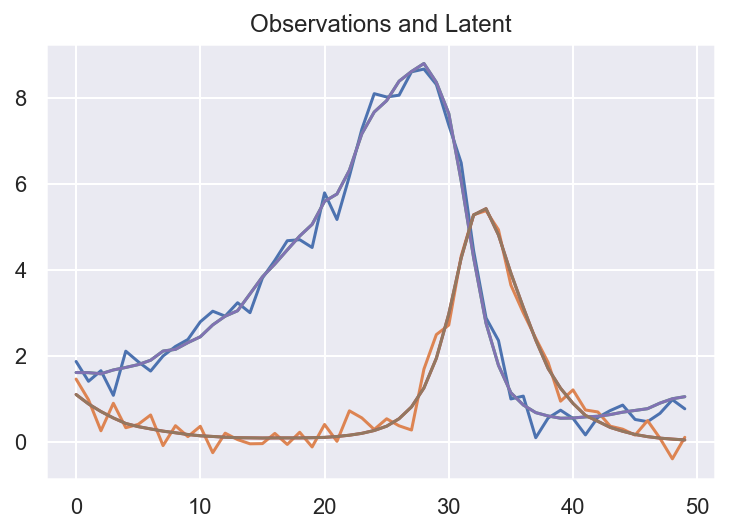

In [4]:
plt.plot(y_meas[:, 0])
plt.plot(y_meas[:, 1])
plt.plot(jnp.exp(x_state[:,0]))
plt.plot(jnp.exp(x_state[:, 1]))
plt.title("Observations and Latent");

## Parameter Estimation with Complete Data

In other words, we estimate $\theta$ as if both $y_{0:T}$ and $x_{0:T}$ were known.  Let's start with projection plots of the complete data (log)likelihood

$$
\ell(\theta \mid x_{0:T}, y_{0:T}) = \log p(y_0 \mid x_0, \theta) + \sum_{t=1}^T \log p(y_t \mid x_t, \theta) + \log p(x_t \mid x_{t-1}, \theta).
$$

In [6]:
theta_lims = np.array([[0.8, 1.2], [.75, 1.2], [3.5, 4.5], [0.8, 1.2],
                       [.05, .2], [.05, .2], [.1, .5], [.1, .5]])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

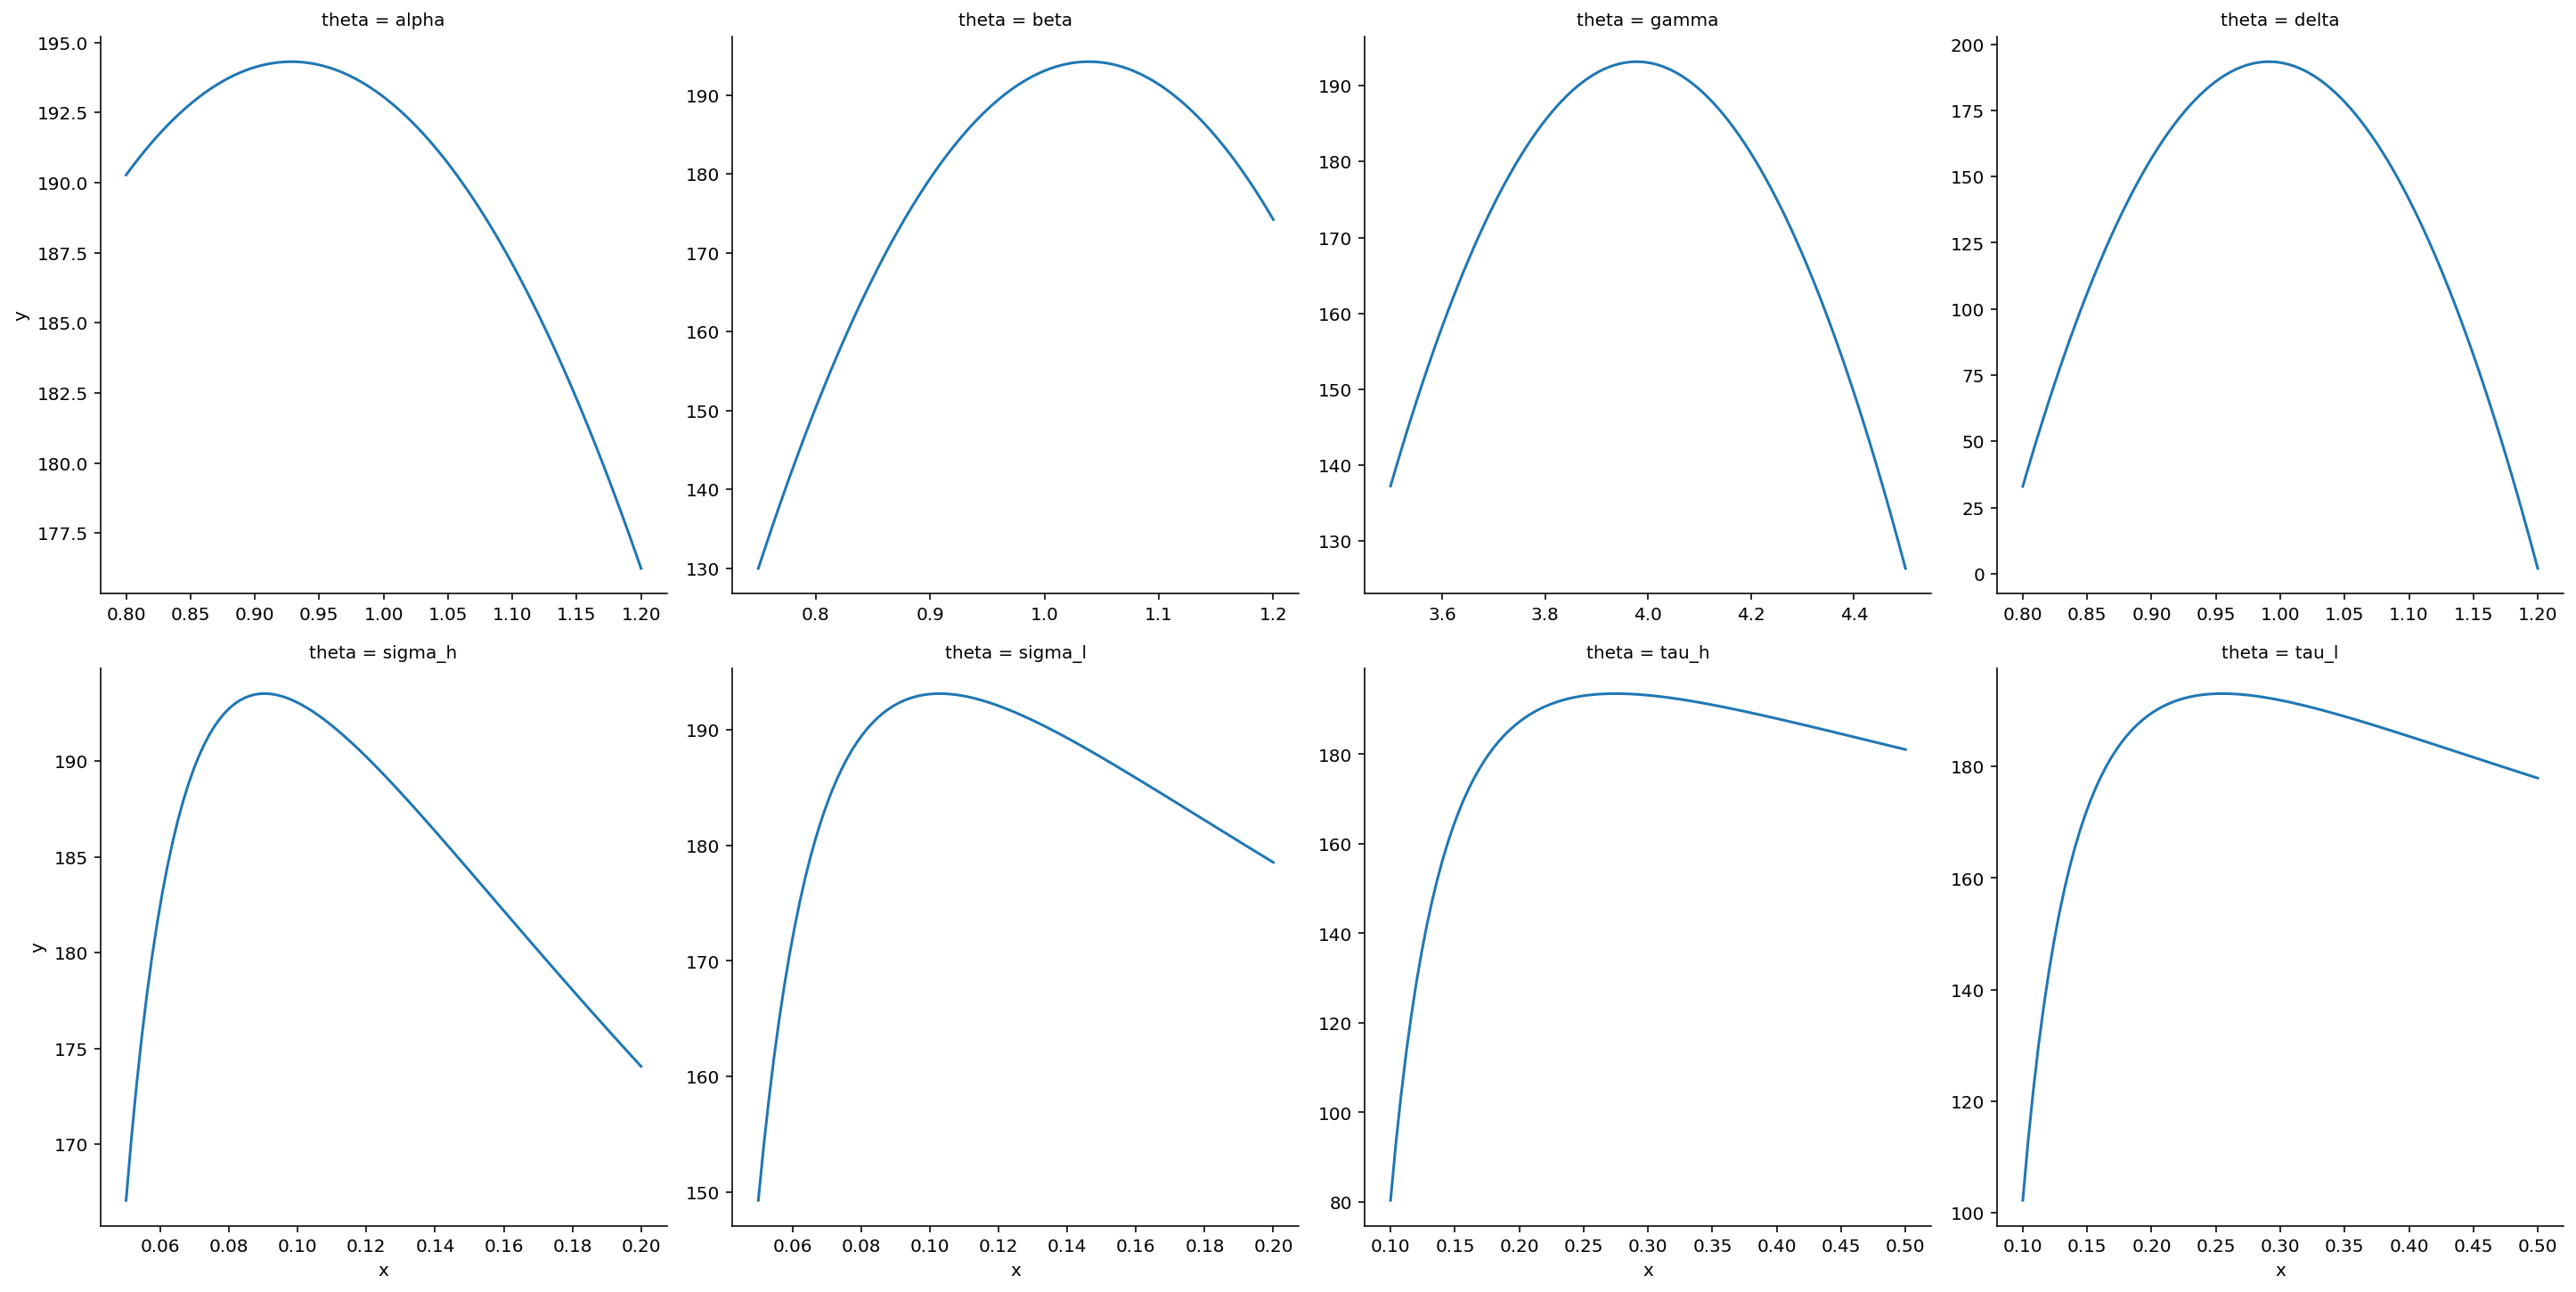

In [6]:
# calculate projection plot
@jax.jit
def lotvol_loglik(theta):
    return joint_loglik(model=lotvol_model, theta=theta, x_state=x_state, y_meas=y_meas)

plot_df = proj_data(lotvol_loglik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
);

## Parameter Estimation with Particle Filter

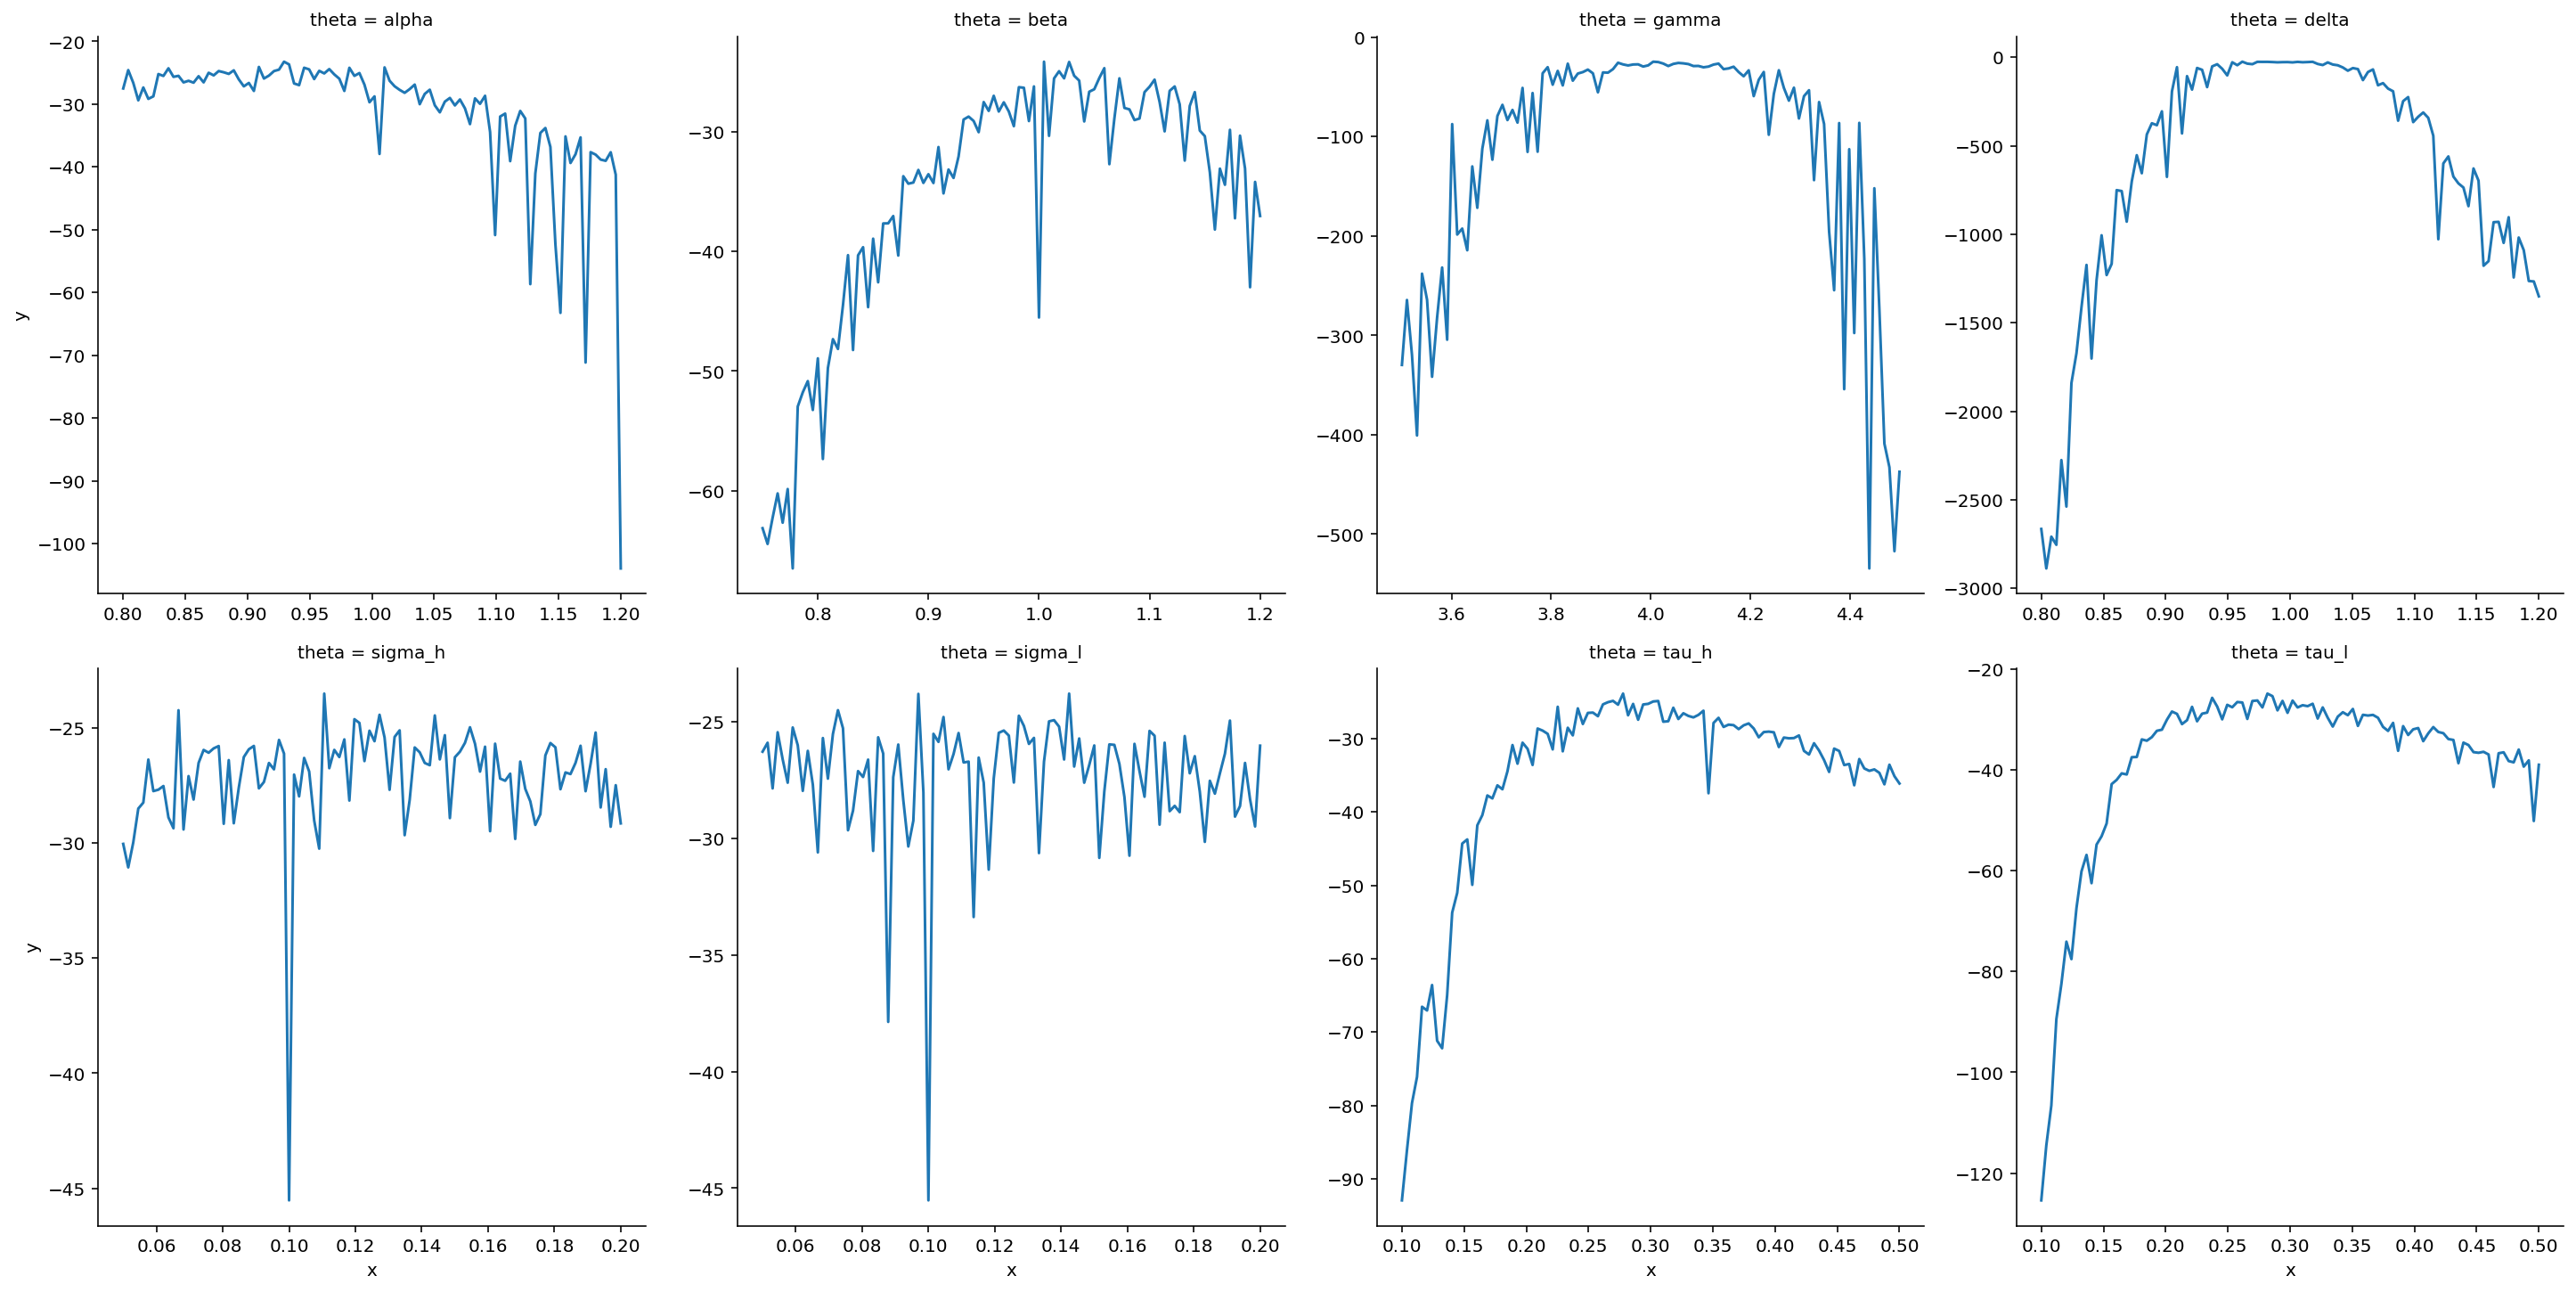

In [7]:
# calculate projection plot
n_particles = 100

@jax.jit
def lotvol_pflik(theta):
    temp = pf(theta=theta, model=lotvol_model, y_meas=y_meas,
                                 n_particles=n_particles, key=key)
    return particle_loglik(temp['logw_particles'])

plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
);

## Parameter Estimation with Particle Filter using MVN Approx.

In [7]:
n_particles = 100

@jax.jit
def lotvol_pflik(theta):
    temp = pfmvn.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                                 n_particles=n_particles, key=key)
    return particle_loglik(temp['logw_particles'])


plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
);

TypeError: _cond() missing 1 required positional argument: 'operand'

### Stochastic Optimization

For now, we initialize it to be the starting values that were chosen. In addition to this, we also initialize the mask array to be this so that we can verify the results on a one dimensional optimization problem.

### Experimental Notes

- The MVN approximation makes the log-likelihood **much** smoother. This is noticable in the optimization, for example the bootstrap particle filter diverges for `{learning_rate = 1e-4, n_particles=1000}`, but the MVN approximation is able to converge with the same learning rate and half the particles (500). This is with the initial values as the true paramters. 
- 

#### PF MVN

In [8]:
from pfjax import stoch_opt  # get_sum_lweights

In [9]:
params, so, grads = stoch_opt(lotvol_model, 
                              params = jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.25, 0.25]), 
                            #   params = jnp.array(np.random.random(len(theta))),
                              grad_fun = pfmvn.get_sum_lweights_mvn, 
                              y_meas = y_meas, key=key, 
                              learning_rate=1e-5, 
                              iterations=1000, n_particles=50
                              ,mask=np.array([1,1,1,1,1,1,1,1]))

print("Estimated params: {0}".format(list(round(params, 1))))
print("True params: {0}".format(list(theta)))

Estimated params: [0.90000004, 1.0, 3.9, 1.0, 0.0, 0.0, 0.3, 0.3]
True params: [1.0, 1.0, 4.0, 1.0, 0.1, 0.1, 0.25, 0.25]


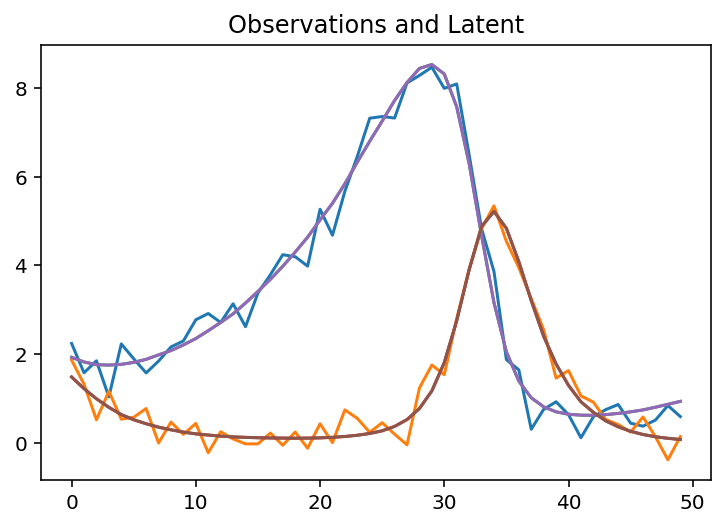

In [10]:
x_init_est = lotvol_model.init_sample(y_init=jnp.log(jnp.array([5., 3.])),
                                  theta=params,
                                  key=subkey)

y_meas_est, x_state_est = simulate(lotvol_model, 
                                   n_obs, 
                                   x_init_est, 
                                   params, 
                                   subkey)

plt.plot(y_meas_est[:, 0], label = "observed y[0]")
plt.plot(y_meas_est[:, 1], label="observed y[1]")
plt.plot(jnp.exp(x_state_est[:, 0]), label="latent x[0]")
plt.plot(jnp.exp(x_state_est[:, 1]), label="latent x[0]")
plt.title("Observations and Latent");

### Pf

In [11]:
from pfjax.particle_filter import get_sum_lweights

In [12]:
pf_params, pf_so, pf_grads = stoch_opt(lotvol_model, 
                              params = jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.25, 0.25]), 
#                               params = jnp.array(np.random.random(len(theta))*0.001),
                              grad_fun = get_sum_lweights, 
                              y_meas = y_meas, key=key, 
                              learning_rate=1e-6, 
                              iterations=1000, n_particles=50
                              ,mask=np.array([1,1,1,1,1,1,1,1]))

print("Estimated params: {0}".format(list(round(pf_params, 1))))
print("True params: {0}".format(list(theta)))

Estimated params: [0.90000004, 1.0, 4.0, 1.0, 0.0, 0.1, 0.3, 0.3]
True params: [1.0, 1.0, 4.0, 1.0, 0.1, 0.1, 0.25, 0.25]


## Laplace Approximation

- Define priors: $\pi(\theta)$
- Construct posterior
- Find theta hat argmax(posterior)

**Dont understand**: Fisher information is the negative Hessian of the log-likelihood, which is the variance of the score function, but the score function is the first derivative of the log-likelihood. Alternatively, we can approximate the log-likelihood with a Laplace approximation for which we have the inverse of the Hessian as the variance parameter. So the variance of the log-likelihood and the variance of the Score function are the same thing? Or is this only if the log-likelihood is evaluated at the maxinimum (MLE)?

In [122]:
from jax.scipy.stats import multivariate_normal
from jax import random

prior_means = theta
prior_cov = jnp.diag(theta)

def prior(x): 
    return multivariate_normal.pdf(
    x, prior_means, prior_cov)

params, so, grads = stoch_opt(lotvol_model,
                              params=jnp.array([1., 1., 4., 1., 0.1, 0.1, 0.25, 0.25]),
                            #   params=jnp.array(np.random.random(len(theta))*0.01),
                              grad_fun=pfmvn.log_posterior,
                              y_meas=y_meas, key=key,
                              learning_rate=1e-5, iterations=1000, 
                              n_particles=100, 
                              mask=np.array([1, 1, 1, 1, 1, 1, 1, 1]),
                              prior=prior)

print("Estimated params: {0}".format(list(round(params, 1))))
print("True params: {0}".format(list(theta)))

Estimated params: [0.90000004, 1.0, 3.9, 1.0, 0.0, 0.0, 0.3, 0.3]
True params: [1.0, 1.0, 4.0, 1.0, 0.1, 0.1, 0.25, 0.25]


In [37]:
# hessian: 
key = random.PRNGKey(42)
key, subkey = random.split(key)

hessian = jax.jacfwd(jax.jacrev(pfmvn.log_posterior))

# should increase the number of particles here, since we want a one-time accurate approx. of the loglik
hess = hessian(params, key, n_particles=1000, y_meas=y_meas, model=lotvol_model, prior=prior)
theta_hat = params
var_hat = jnp.linalg.inv(hess)

In [69]:
n_post_samples = 2000
posterior_samples = random.multivariate_normal(key=key, mean=theta_hat, cov=-var_hat, shape=(n_post_samples, ))

# find 95% credible intervals
theta_U = jnp.quantile(posterior_samples, q=0.95, axis=0)
theta_L = jnp.quantile(posterior_samples, q=0.05, axis=0)

theta_L, theta_U

theta_L = list(map(lambda x: max(x, 1e-5), theta_L)) # trickery to remove negative values from lower bound

(DeviceArray([ 0.8701446 ,  0.9485812 ,  3.4051433 ,  0.87066334,
              -0.0287452 , -0.06128052,  0.24657655,  0.21331668],            dtype=float32),
 DeviceArray([0.9528247 , 1.045773  , 3.8756106 , 0.9772026 , 0.03077834,
              0.06676323, 0.34444556, 0.29883558], dtype=float32))

In [114]:
# forward simulate data with lower confidence interval:
x_init_L = lotvol_model.init_sample(y_init=jnp.log(jnp.array([5., 3.])),
                                      theta=theta_L,
                                      key=subkey)

y_meas_L, x_state_L = simulate(lotvol_model,
                               n_obs,
                               x_init_L,
                               theta_L,
                               subkey)
lower_bound = pd.DataFrame(y_meas_L)
lower_bound.columns = ["obs_0", "obs_1"]
lower_bound["latent_0"] = jnp.exp(jnp.squeeze(x_state_L)[:, 0])
lower_bound["latent_1"] = jnp.exp(jnp.squeeze(x_state_L)[:, 1])
lower_bound["time"] = lower_bound.index

# forward simulate data with upper confidence interval:
x_init_U = lotvol_model.init_sample(y_init=jnp.log(jnp.array([5., 3.])),
                                    theta=theta_U,
                                    key=subkey)

y_meas_U, x_state_U = simulate(lotvol_model,
                               n_obs,
                               x_init_U,
                               theta_U,
                               subkey)
upper_bound = pd.DataFrame(y_meas_U)
upper_bound.columns = ["obs_0", "obs_1"]
upper_bound["latent_0"] = jnp.exp(jnp.squeeze(x_state_U)[:, 0])
upper_bound["latent_1"] = jnp.exp(jnp.squeeze(x_state_U)[:, 1])
upper_bound["time"] = upper_bound.index

# populate df with true data: 
true_data = pd.DataFrame(y_meas)
true_data.columns = ["obs_0", "obs_1"]
true_data["latent_0"] = jnp.exp(jnp.squeeze(x_state)[:, 0])
true_data["latent_1"] = jnp.exp(jnp.squeeze(x_state)[:, 1])
true_data["time"] = true_data.index


In [115]:
all_data = pd.concat([lower_bound, upper_bound, true_data]).reset_index(drop = True)
all_data.shape
pd.melt(all_data, id_vars="time").head()

(150, 5)

,time,variable,value
0,0,obs_0,2.259864
1,1,obs_0,1.695642
2,2,obs_0,1.712983
3,3,obs_0,2.129953
4,4,obs_0,1.904538


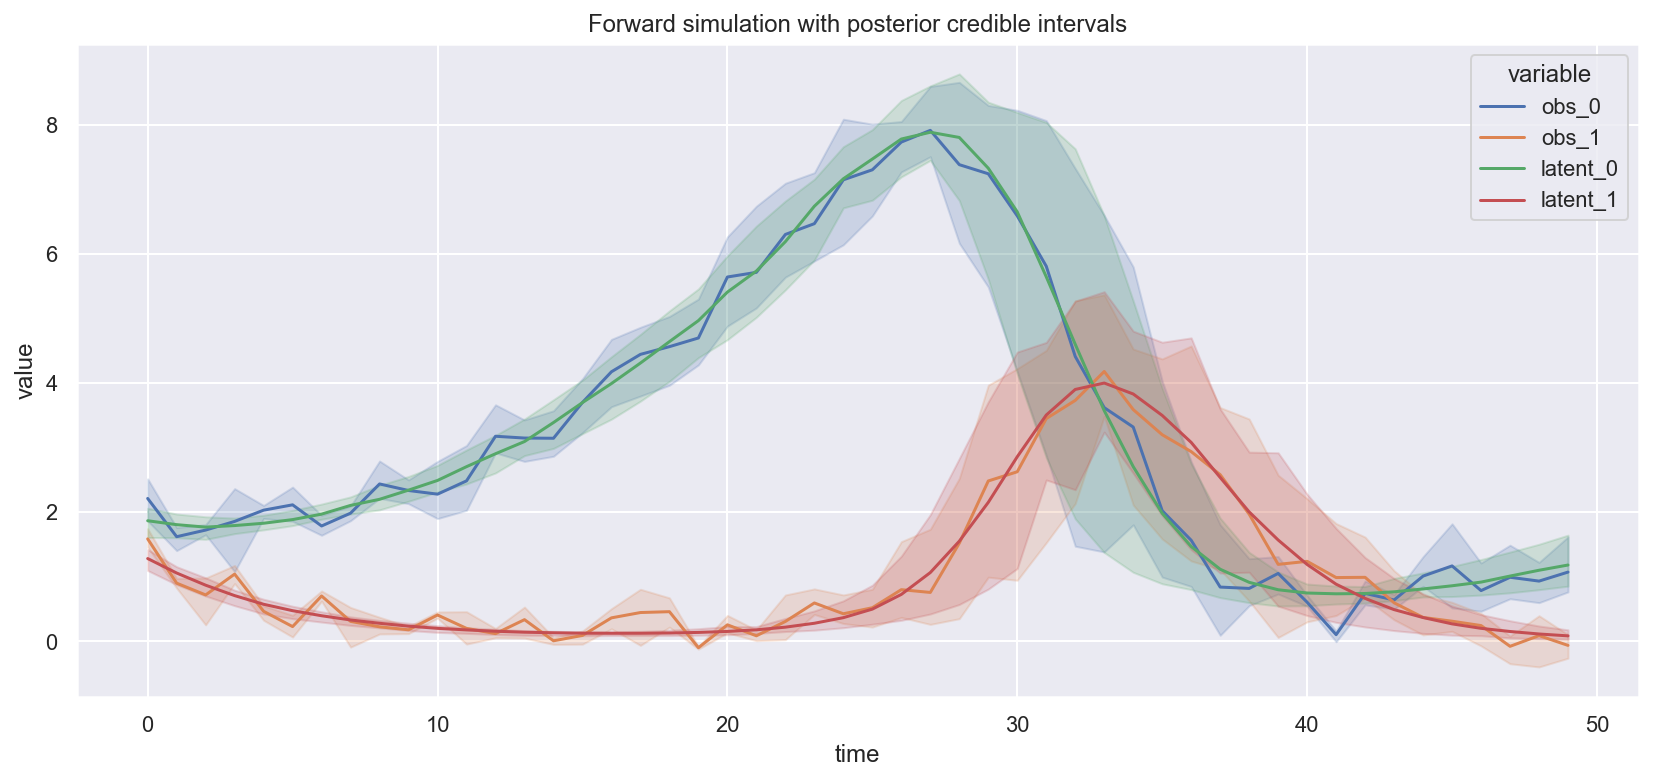

In [117]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6), sharey=True)
sns.lineplot(data=pd.melt(all_data, id_vars = "time"), x="time", y="value", hue="variable")\
    .set_title("Forward simulation with posterior credible intervals");